# CORDEX Regional Climate Projections

...

In [1]:
import geopandas as gpd
import xarray as xr

In [33]:
org_units = gpd.read_file('../test_data/sierra-leone-districts.geojson')
org_units

,type,id,name,hasCoordinatesDown,hasCoordinatesUp,level,grandParentParentGraph,grandParentId,parentGraph,parentId,parentName,dimensions,weight,geometry
0,Polygon,O6uvpzGd5pu,Bo,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"POLYGON ((-11.5914 8.4875, -11.5906 8.4769, -1..."
1,Polygon,fdc6uOvgoji,Bombali,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"POLYGON ((-11.8091 9.2032, -11.8102 9.1944, -1..."
2,MultiPolygon,lc3eMKXaEfw,Bonthe,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"MULTIPOLYGON (((-12.5568 7.3832, -12.5574 7.38..."
3,Polygon,jUb8gELQApl,Kailahun,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"POLYGON ((-10.7972 7.5866, -10.8002 7.5878, -1..."
4,MultiPolygon,PMa2VCrupOd,Kambia,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"MULTIPOLYGON (((-13.1349 8.8471, -13.1343 8.84..."
5,Polygon,kJq2mPyFEHo,Kenema,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"POLYGON ((-11.3596 8.5317, -11.3513 8.5234, -1..."
6,Polygon,qhqAxPSTUXp,Koinadugu,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"POLYGON ((-10.585 9.0434, -10.5877 9.0432, -10..."
7,Polygon,Vth0fbpFcsO,Kono,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"POLYGON ((-10.585 9.0434, -10.5848 9.0432, -10..."
8,MultiPolygon,jmIPBj66vD6,Moyamba,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"MULTIPOLYGON (((-12.6351 7.6613, -12.6346 7.66..."
9,MultiPolygon,TEQlaapDQoK,Port Loko,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"MULTIPOLYGON (((-13.119 8.4718, -13.1174 8.470..."


In [22]:
# valid variable names
# - "2m_air_temperature",
# - "2m_relative_humidity",
# - "mean_precipitation_flux"

import earthkit.data
import json
import shutil
from pathlib import Path

def model_name_to_stub(name):
    return name.replace('-', '_').lower()

model_combinations = {}

model_combinations['africa'] = {
    'MOHC-HadGEM2-ES': [
        'CLMcom-KIT-CCLM5-0-15',
        'GERICS-REMO2015',
        'ICTP-RegCM4-7',
    ],
    'MPI-M-MPI-ESM-MR': [
        'ICTP-RegCM4-7'
    ],
    'NCC-NorESM1-M': [
        'CLMcom-KIT-CCLM5-0-15',
        'GERICS-REMO2015',
        'ICTP-RegCM4-7',
    ],
    'MPI-M-MPI-ESM-LR': [
        'CLMcom-KIT-CCLM5-0-15',
        'GERICS-REMO2015',
    ]
}

# TODO: rcm 'ICTP-RegCM4-7' uses yearly rather than 5 yearly downloads, need to handle differently... 
skip_rcms = ['ICTP-RegCM4-7']

allowed_start_years = list(range(2006, 2091+1, 5))
allowed_end_years = list(range(2010, 2095+1, 5))

def get_year_block(start_year, end_year, region, save_path, variables, scenario, resolution, gcm_model, rcm_model):
    # construct the query parameters
    params = {
        "domain": region,
        "experiment": scenario,
        "horizontal_resolution": resolution,
        "temporal_resolution": "daily_mean",
        "variable": variables,
        "gcm_model": model_name_to_stub(gcm_model),
        "rcm_model": model_name_to_stub(rcm_model),
        "ensemble_member": "r1i1p1",
        "start_year": [str(start_year)],
        "end_year": [str(end_year)],
    }

    # download the data
    print(f'Downloading climate projection data from CDS API...')
    print(f'Request parameters: \n{json.dumps(params)}')
    data = earthkit.data.from_source("cds",
        "projections-cordex-domains-single-levels",
        **params
    )

    print('Download finished:', data)
    shutil.copyfile(data.path, save_path)
    return save_path

    # if hasattr(data, 'path'):
    #     # single file
    #     paths = [data.path]
    # elif hasattr(data, 'sources'):
    #     # multiple files
    #     paths = [source.path for source in data.sources]
    # # copy from downloaded path to user specified path
    # files = []
    # for path in paths:
    #     file_start_year = path.replace('-', '_').split('_')[-2][:4]
    #     file_end_year = path.replace('-', '_').split('_')[-1][:4]
    #     out_path = Path(dirname).resolve() / f'{prefix}_{file_start_year}-{file_end_year}.nc'
    #     shutil.copyfile(path, out_path)
    #     #data.to_target('file', out_path)
    #     files.append(out_path)

def get(start_date, end_date, region, dirname, prefix, variables, scenario, resolution, gcm_model, rcm_model, overwrite=False):
    start_year = int(str(start_date)[:4])
    end_year = int(str(end_date)[:4])
    start_years = [str(y) for y in allowed_start_years if start_year <= y <= end_year]
    end_years = [str(y) for y in allowed_end_years if start_year <= y <= end_year]

    files = []
    for start_year, end_year in zip(start_years, end_years):
        print(f'Years {start_year} to {end_year}')
        out_path = Path(dirname).resolve() / f'{prefix}_{start_year}-{end_year}.nc'
        if overwrite is False and out_path.exists():
            print('File already exists, reusing from cache', out_path)
            files.append(out_path)
            continue
        else:
            file = get_year_block(start_year, end_year, region, out_path, variables, scenario, resolution, gcm_model, rcm_model)
            files.append(file)

    # return
    return files

start_year = 2021
end_year = 2030
dirname = '../test_outputs/cordex'
variables = ['2m_air_temperature']
region = 'africa'
scenario = 'rcp_2_6'
resolution = '0_22_degree_x_0_22_degree'
files = []
for gcm_model,rcm_models in model_combinations['africa'].items():
    for rcm_model in rcm_models:
        prefix = f'cordex_temperature_{scenario}_{gcm_model}_{rcm_model}'
        print(prefix)
        if rcm_model in skip_rcms:
            print('Skipping RCM...')
            continue
        subfiles = get(start_year, end_year, region, dirname, prefix, variables, scenario, resolution, gcm_model, rcm_model)
        print(subfiles)
        files.extend(subfiles)

files

cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15
Years 2021 to 2025
File already exists, reusing from cache C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2021-2025.nc
Years 2026 to 2030
File already exists, reusing from cache C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2026-2030.nc
[WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2021-2025.nc'), WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2026-2030.nc')]
cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_GERICS-REMO2015
Years 2021 to 2025
File already exists, reusing from cache C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_tempera

[WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2021-2025.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2026-2030.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_GERICS-REMO2015_2021-2025.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_GERICS-REMO2015_2026-2030.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15_2021-2025.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15_2026-2030.nc'),
 WindowsPath('C:/Users/karimba/Documen

In [42]:
import cftime
import pandas as pd
import numpy as np

def extract_ymdh(t):
    """
    Extract year, month, day, hour from cftime, pandas, or numpy datetime.
    """
    if isinstance(t, cftime.datetime):
        return t.year, t.month, t.day, t.hour

    if isinstance(t, (np.datetime64, pd.Timestamp)):
        ts = pd.Timestamp(t)
        return ts.year, ts.month, ts.day, ts.hour

    raise TypeError(f"Unsupported time type: {type(t)}")

def normalize_calendar(ds, target_cal="365_day"):
    cal = (
        ds.time.encoding.get("calendar")
        or ds.time.attrs.get("calendar")
        or "standard"
    )

    print(f'Converting from calendar {cal} to {target_cal}')

    t0 = ds.time.values[0]
    year, month, day, hour = extract_ymdh(t0)

    norm_time = xr.cftime_range(
        start=cftime.datetime(
            year, month, day, hour, calendar=target_cal
        ),
        periods=ds.sizes["time"],
        freq="D",
        calendar=target_cal,
    )
    numpy_time = norm_time.to_datetimeindex()

    ds = ds.copy()
    ds["time"] = numpy_time
    ds.time.attrs["original_calendar"] = cal
    ds.time.encoding["calendar"] = target_cal

    return ds

# collect and prep files before concat
datasets = []
for fil in files:
    d = xr.open_dataset(fil, chunks={"time": 30})
    # need to normalize slightly different calendar definitions
    d = normalize_calendar(d)
    # make gcm-rcm combo a dimension that we can select on after concat
    ensemble_id = f'{d.model_id}__{d.driving_model_id}'
    d = d.assign_coords(ensemble=ensemble_id).expand_dims("ensemble")
    datasets.append(d)

# concat
ds = xr.concat(
    datasets, 
    dim="ensemble",
    data_vars="minimal",
    coords="minimal",
    compat="override"
)
ds

Converting from calendar 360_day to 365_day


C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:30: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  norm_time = xr.cftime_range(
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  numpy_time = norm_time.to_datetimeindex()
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  numpy_time = norm_time.to_datetimeindex()


Converting from calendar 360_day to 365_day


C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:30: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  norm_time = xr.cftime_range(
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  numpy_time = norm_time.to_datetimeindex()
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  numpy_time = norm_time.to_datetimeindex()


Converting from calendar 360_day to 365_day


C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:30: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  norm_time = xr.cftime_range(
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  numpy_time = norm_time.to_datetimeindex()
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  numpy_time = norm_time.to_datetimeindex()


Converting from calendar 360_day to 365_day


C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:30: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  norm_time = xr.cftime_range(
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  numpy_time = norm_time.to_datetimeindex()
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  numpy_time = norm_time.to_datetimeindex()


Converting from calendar 365_day to 365_day


C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:30: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  norm_time = xr.cftime_range(
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  numpy_time = norm_time.to_datetimeindex()
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  numpy_time = norm_time.to_datetimeindex()


Converting from calendar 365_day to 365_day


C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:30: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  norm_time = xr.cftime_range(
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  numpy_time = norm_time.to_datetimeindex()
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  numpy_time = norm_time.to_datetimeindex()


Converting from calendar proleptic_gregorian to 365_day


C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:30: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  norm_time = xr.cftime_range(
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  numpy_time = norm_time.to_datetimeindex()
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  numpy_time = norm_time.to_datetimeindex()


Converting from calendar proleptic_gregorian to 365_day


C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:30: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  norm_time = xr.cftime_range(
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  numpy_time = norm_time.to_datetimeindex()
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  numpy_time = norm_time.to_datetimeindex()


Converting from calendar standard to 365_day


C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:30: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  norm_time = xr.cftime_range(
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  numpy_time = norm_time.to_datetimeindex()
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  numpy_time = norm_time.to_datetimeindex()


Converting from calendar standard to 365_day


C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:30: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  norm_time = xr.cftime_range(
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  numpy_time = norm_time.to_datetimeindex()
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  numpy_time = norm_time.to_datetimeindex()


Converting from calendar proleptic_gregorian to 365_day


C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:30: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  norm_time = xr.cftime_range(
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  numpy_time = norm_time.to_datetimeindex()
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  numpy_time = norm_time.to_datetimeindex()


Converting from calendar proleptic_gregorian to 365_day


C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:30: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  norm_time = xr.cftime_range(
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  numpy_time = norm_time.to_datetimeindex()
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2498814355.py:38: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  numpy_time = norm_time.to_datetimeindex()
C:\Users\karimba\AppData\Local\Temp\ipykernel_34108\2

<xarray.Dataset> Size: 108GB
Dimensions:                     (ensemble: 12, time: 3651, rlat: 805,
                                 rlon: 764, bnds: 2, vertices: 4)
Coordinates:
  * ensemble                    (ensemble) <U39 2kB 'CLMcom-KIT-CCLM5-0-15__M...
  * time                        (time) datetime64[ns] 29kB 2021-01-01T12:00:0...
  * rlat                        (rlat) float64 6kB -47.63 -47.41 ... 43.67 43.89
  * rlon                        (rlon) float64 6kB -24.75 -24.53 ... 60.17 60.39
    lon                         (rlat, rlon) float64 5MB dask.array<chunksize=(402, 388), meta=np.ndarray>
    lat                         (rlat, rlon) float64 5MB dask.array<chunksize=(402, 388), meta=np.ndarray>
    height                      float64 8B ...
Dimensions without coordinates: bnds, vertices
Data variables:
    rotated_pole                (ensemble) object 96B b'' b'' nan ... nan nan
    tas                         (ensemble, time, rlat, rlon) float32 108GB dask.array<chunksize=(1, 29, 402, 385), meta=np.ndarray>
    time_bnds                   (ensemble, time, bnds) object 701kB dask.array<chunksize=(1, 29, 2), meta=np.ndarray>
    rotated_latitude_longitude  (ensemble) float64 96B nan nan ... -2.147e+09
    lat_vertices                (ensemble, rlat, rlon, vertices) float32 118MB dask.array<chunksize=(1, 417, 385, 4), meta=np.ndarray>
    lon_vertices                (ensemble, rlat, rlon, vertices) float32 118MB dask.array<chunksize=(1, 417, 385, 4), meta=np.ndarray>
Attributes: (12/26)
    title:                          CCLMcom-KIT-CCLM5-0-15 model output prepa...
    project_id:                     CORDEX
    CORDEX_domain:                  AFR-22
    driving_model_id:               MOHC-HadGEM2-ES
    experiment_id:                  rcp26
    driving_experiment_name:        rcp26
    ...                             ...
    comment:                        Please use the following reference for th...
    product:                        output
    frequency:                      day
    creation_date:                  2019-11-29-T11:13:21Z
    tracking_id:                    hdl:21.14103/d14daa20-c089-42a4-a605-7650...
    c3s_disclaimer:                 This data has been curated and prepared i...

In [76]:
# test subset to bbox
xmin,ymin,xmax,ymax = map(float, org_units.total_bounds)

mask = (
    (ds.lat >= ymin) & (ds.lat <= ymax) &
    (ds.lon >= xmin)  & (ds.lon <= xmax)
).compute()

ds_subset = ds.where(mask, drop=True).compute()
ds_subset

<xarray.Dataset> Size: 160MB
Dimensions:                     (ensemble: 12, rlat: 14, rlon: 13, time: 3651,
                                 bnds: 2, vertices: 4)
Coordinates:
  * ensemble                    (ensemble) <U39 2kB 'CLMcom-KIT-CCLM5-0-15__M...
  * rlat                        (rlat) float64 112B 6.93 7.15 7.37 ... 9.57 9.79
  * rlon                        (rlon) float64 104B -13.09 -12.87 ... -10.45
  * time                        (time) datetime64[ns] 29kB 2021-01-01T12:00:0...
    lon                         (rlat, rlon) float64 1kB -13.09 ... -10.45
    lat                         (rlat, rlon) float64 1kB 6.93 6.93 ... 9.79 9.79
    height                      float64 8B 2.0
Dimensions without coordinates: bnds, vertices
Data variables:
    rotated_pole                (ensemble, rlat, rlon) object 17kB b'' ... nan
    tas                         (ensemble, time, rlat, rlon) float32 32MB 300...
    time_bnds                   (ensemble, time, bnds, rlat, rlon) object 128MB ...
    rotated_latitude_longitude  (ensemble, rlat, rlon) float64 17kB nan ... -...
    lat_vertices                (ensemble, rlat, rlon, vertices) float32 35kB ...
    lon_vertices                (ensemble, rlat, rlon, vertices) float32 35kB ...
Attributes: (12/26)
    title:                          CCLMcom-KIT-CCLM5-0-15 model output prepa...
    project_id:                     CORDEX
    CORDEX_domain:                  AFR-22
    driving_model_id:               MOHC-HadGEM2-ES
    experiment_id:                  rcp26
    driving_experiment_name:        rcp26
    ...                             ...
    comment:                        Please use the following reference for th...
    product:                        output
    frequency:                      day
    creation_date:                  2019-11-29-T11:13:21Z
    tracking_id:                    hdl:21.14103/d14daa20-c089-42a4-a605-7650...
    c3s_disclaimer:                 This data has been curated and prepared i...

In [77]:
# convert to celsius
ds_subset['tas'] = ds_subset.tas - 273.15

In [78]:
# calc ensemble stats
tas_mean = ds_subset.tas.mean(dim="ensemble")
tas_min = ds_subset.tas.min(dim="ensemble")
tas_max = ds_subset.tas.max(dim="ensemble")

Stat 24.73433
Stat 25.51466
Stat 26.139145


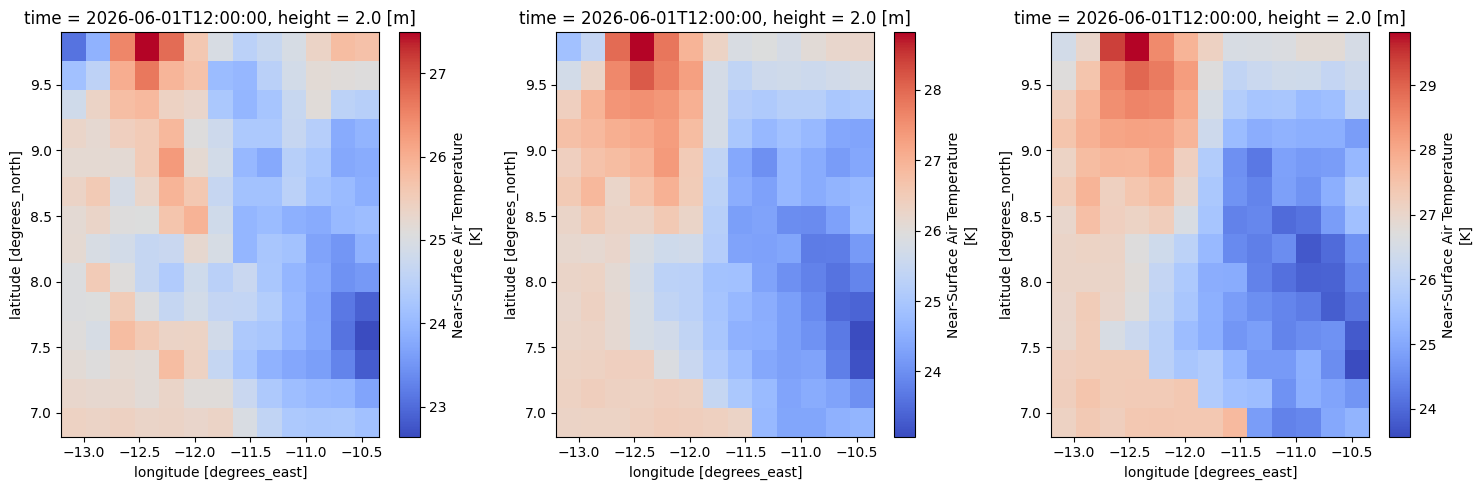

In [79]:
# make multiplot, 2026

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15,5))

# maps in order min, mean, max
date = '2026-06-01'
for ax, d in zip(axes, [tas_min, tas_mean, tas_max]):
    print('Stat', d.sel(time=date).mean().values)
    d.sel(time=date).plot(ax=ax, x="lon", y="lat", cmap="coolwarm")
    #ax.set_title(stat)

plt.tight_layout()
plt.show()

Stat 24.929527
Stat 25.761116
Stat 26.498844


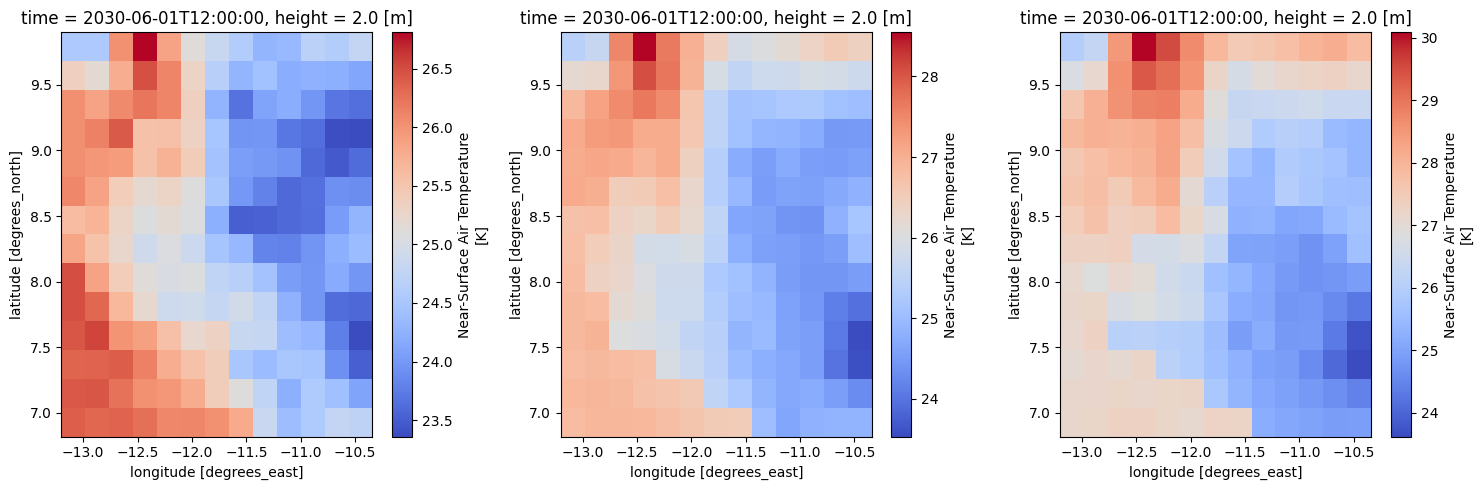

In [81]:
# make multiplot, 2030

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15,5))

# maps in order min, mean, max
date = '2030-06-01'
for ax, d in zip(axes, [tas_min, tas_mean, tas_max]):
    print('Stat', d.sel(time=date).mean().values)
    d.sel(time=date).plot(ax=ax, x="lon", y="lat", cmap="coolwarm")
    #ax.set_title(stat)

plt.tight_layout()
plt.show()

In [ ]:
tas_mean.mean(dim=["rlat","rlon"]).groupby("time.year").count(dim="time").to_dataframe().reset_index()

,year,height,tas
0,2021,2.0,365
1,2022,2.0,365
2,2023,2.0,365
3,2024,2.0,365
4,2025,2.0,365
5,2026,2.0,365
6,2027,2.0,365
7,2028,2.0,365
8,2029,2.0,365
9,2030,2.0,365


In [87]:
# aggregate by year for whole country
tas_mean_yr = tas_mean.resample(time="Y").mean(dim="time").mean(dim=["rlat","rlon"]).compute()
tas_min_yr = tas_min.resample(time="Y").mean(dim="time").mean(dim=["rlat","rlon"]).compute()
tas_max_yr = tas_max.resample(time="Y").mean(dim="time").mean(dim=["rlat","rlon"]).compute()
tas_mean_yr

c:\Users\karimba\AppData\Local\miniconda3\envs\climate-tools-py313\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
c:\Users\karimba\AppData\Local\miniconda3\envs\climate-tools-py313\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
c:\Users\karimba\AppData\Local\miniconda3\envs\climate-tools-py313\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


<xarray.DataArray 'tas' (time: 11)> Size: 44B
array([25.050585, 25.233686, 25.219635, 25.266838, 25.155088, 25.180267,
       25.280235, 25.449701, 25.117605, 25.388533, 22.83066 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 88B 2021-12-31 2022-12-31 ... 2031-12-31
    height   float64 8B 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    cell_methods:   time: mean
    grid_mapping:   rotated_pole

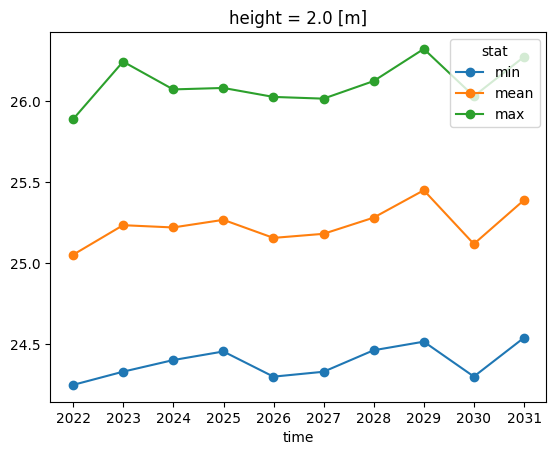

In [83]:
# plot min, mean, max
# should actually be -1 on year values, not sure why
tas_yr = xr.Dataset(
    {
        "min": tas_min_yr,
        "mean": tas_mean_yr,
        "max": tas_max_yr,
    }
)
tas_yr.sel(time=slice('2020', '2030')).to_array("stat").plot(x="time", hue="stat", marker="o", linestyle="-")